In [1]:
pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=60a1882709b39e020e45b807939d05e9ec7b37e8856457f9e6b59d23d0728325
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [2]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.optim.lr_scheduler import StepLR
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [3]:
!git clone  https://github.com/visionenthusiast/source_code.git

Cloning into 'source_code'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 17 (delta 2), reused 14 (delta 2), pack-reused 0
Unpacking objects: 100% (17/17), 7.73 KiB | 1.93 MiB/s, done.


## Import and load Resnet18 model

In [4]:
from source_code.models import resnet
from source_code.utils import gradcam, utils, CIFARdata
model = resnet.ResNet18()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [5]:
import torch
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
summary(model.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## Load CIFAR train and test data loaders

In [7]:
#set batch size
batch_size = 32

#load training dataset
classes, train_loader = CIFARdata.load_CIFAR(train = True, batch_size = batch_size)
#load test dataset
_, test_loader = CIFARdata.load_CIFAR(train = False, batch_size = batch_size)

len(train_loader), len(test_loader)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/data/cifar10/cifar-10-python.tar.gz to /root/data/cifar10
Files already downloaded and verified


(1563, 313)

## View sample images

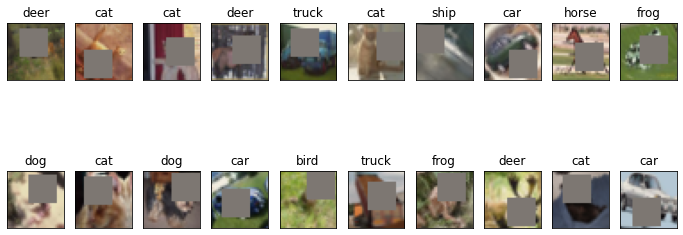

In [8]:

from source_code.utils import utils
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))

no_images = 20

figure = plt.figure(figsize=(12, 5))

for index in range(1, no_images + 1):
    plt.subplot(2, 10, index)
    utils.imshow(images[index - 1])
    plt.tick_params(left=False, right=False, labelleft=False,
                    labelbottom=False, bottom=False)
    title = str(classes[labels[index - 1]])
    plt.title(title)


## Train model for 20 Epochs with CIFAR train data loader

In [9]:
from source_code import main
model, train_losses, train_acc_all, test_losses, test_acc_all = main.train_model(model, train_loader, test_loader, device, epochs=20)

Epoch:  0 Learning Rate:  0.1

Train set: Average loss: 2.2244, Accuracy: 13494.0/50000 (26.99%)


Test set: Average loss: 0.0531, Accuracy: 3690/10000 (36.90%)

Epoch:  1 Learning Rate:  0.1

Train set: Average loss: 1.5835, Accuracy: 18479.0/50000 (36.96%)


Test set: Average loss: 0.0479, Accuracy: 4284/10000 (42.84%)

Epoch:  2 Learning Rate:  0.1

Train set: Average loss: 0.9087, Accuracy: 21132.0/50000 (42.26%)


Test set: Average loss: 0.0459, Accuracy: 4631/10000 (46.31%)

Epoch:  3 Learning Rate:  0.1

Train set: Average loss: 1.0675, Accuracy: 22910.0/50000 (45.82%)


Test set: Average loss: 0.0420, Accuracy: 5145/10000 (51.45%)

Epoch:  4 Learning Rate:  0.1

Train set: Average loss: 1.1206, Accuracy: 24883.0/50000 (49.77%)


Test set: Average loss: 0.0400, Accuracy: 5409/10000 (54.09%)

Epoch:  5 Learning Rate:  0.1

Train set: Average loss: 1.2766, Accuracy: 26289.0/50000 (52.58%)


Test set: Average loss: 0.0365, Accuracy: 5821/10000 (58.21%)

Epoch:  6 Learning Rate:  0.

## Save and load model for future use

In [12]:
#torch.save(model.state_dict(), 'resnetmodel.pt')
from google.colab import drive
drive.mount('/content/drive')
#path = "/content/drive/MyDrive/EVA8/ass7/resnetmodel.pt"
path = "/content/drive/MyDrive/resnetmodel.pt"
torch.save(model.state_dict(), path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Model class must be defined somewhere
pretrained_weights = torch.load(path, map_location='cpu')
model.load_state_dict(pretrained_weights)


<All keys matched successfully>

## Plot training/ test Accuracy and Loss

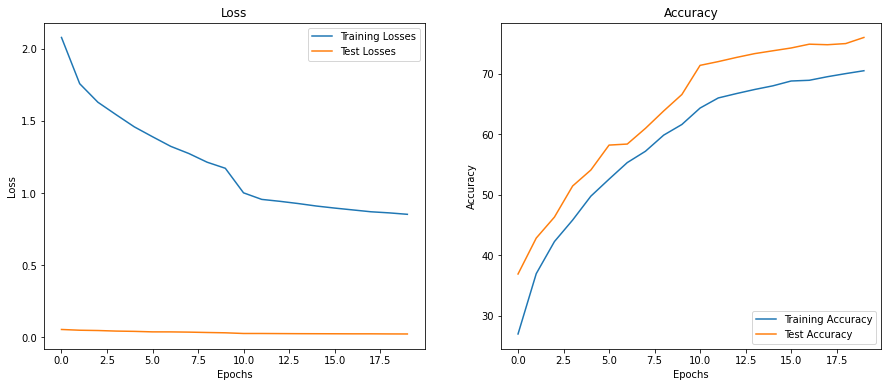

In [15]:
from source_code.utils import utils

utils.plot_LossAndAcc(train_acc_all, train_losses,test_acc_all,test_losses)

## Test Accuracy

In [16]:
from source_code import main

main.test(model, device, test_loader)


Test set: Average loss: 0.0219, Accuracy: 7600/10000 (76.00%)



(0.021866522876918315, 76.0)

## Retrieve data for misclassified images

In [17]:
from source_code.utils import utils

data_images, pred_labels, target_labels = utils.get_mis_classified_byloader(model, device, test_loader)
print(len(data_images), len(pred_labels), len(target_labels))

2400 2400 2400


## Plot mis classified images

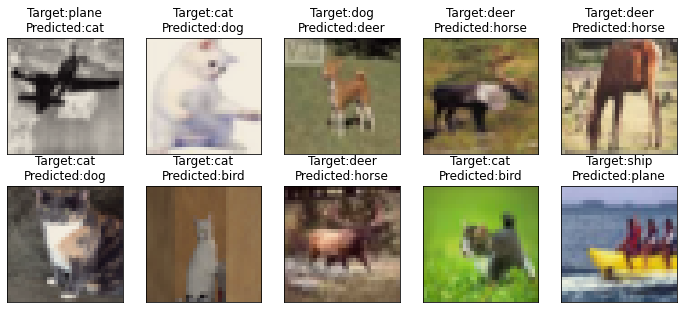

In [18]:
import matplotlib.pyplot as plt
from source_code.utils import utils
        
utils.plot_misclassified(data_images, target_labels, pred_labels, classes, no_images= 10)

## Gradcam

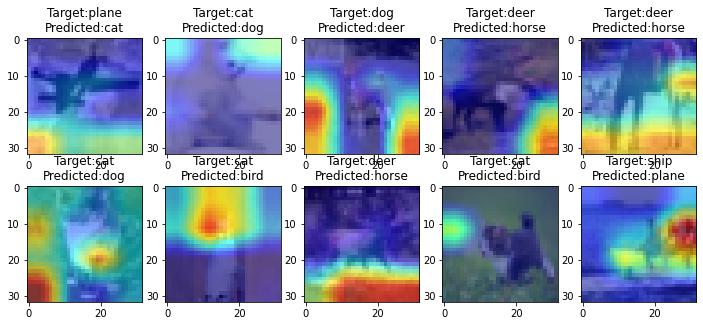

In [19]:
from source_code.utils import gradcam

gradcam.plot_grad_images(model, [model.layer4[-1]], data_images[:10], pred_labels[:10], target_labels[:10], list(range(10)), classes)